### Clone GitHub repository

In [190]:
!git clone https://github.com/vagmarting/TM10007_Group_8.git

fatal: destination path 'TM10007_Group_8' already exists and is not an empty directory.


### Import

In [191]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif, VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import shapiro



### Load data

In [192]:
def load_data():
    data = pd.read_csv(os.path.join('hn','HN_radiomicFeatures.csv'), index_col=0)
    label = data["label"]
    label = label.replace(to_replace={'T12': False, 'T34': True}, value=None)
    data = data.drop(["label"], axis=1)
    return data, label

data, label = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')


The number of samples: 113
The number of columns: 159


### Check for missing data

In [193]:
# Detect missing values in dataframe
data.isnull().values.any()

False

### Data split

In [194]:
def split_data(data, label):
    train_data, test_data, train_label, test_label = train_test_split(data, label, train_size=0.7, stratify=label)
    return train_data, test_data, train_label, test_label

train_data, test_data, train_label, test_label = split_data(data, label)
print(f'The number of train samples: {train_data.shape[0]}')
print(f'The number of test samples: {test_data.shape[0]}')

The number of train samples: 79
The number of test samples: 34


### Preprocessing

In [217]:
def preprocessing(train_data, test_data):
    # Remove features with zero variance
    selector = VarianceThreshold()
    selector.fit_transform(train_data)
    zero_var_col = [column for column in train_data.columns if column not in train_data.columns[selector.get_support()]]
    train_data.drop(zero_var_col, inplace=True, axis=1)
    test_data.drop(zero_var_col, inplace=True, axis=1)
    feature_names = train_data.columns.values

    # Impute median value of feature for outliers
    column_medians = train_data.median()
    train_values = train_data.values
    test_values = test_data.values
    train_mean = train_data.mean()
    train_std = train_data.std()

    for i in range(len(train_values)):
        for j in range(len(train_values[0])):
            if np.abs((train_values[i,j] - train_mean[j]) / train_std[j]) > 3:
                train_values[i,j] = column_medians[j]
    train_data = pd.DataFrame(train_values, columns=feature_names)

    for i in range(len(test_values)):
        for j in range(len(test_values[0])):
            if np.abs((test_values[i,j] - train_mean[j]) / train_std[j]) > 3:
                test_values[i,j] = column_medians[j]
    test_data = pd.DataFrame(test_values, columns=feature_names)

    # Scale features
    scaler = StandardScaler().fit(train_data)
    train_data = scaler.transform(train_data)
    test_data = scaler.transform(test_data)
    train_data = pd.DataFrame(train_data, columns=feature_names)
    test_data = pd.DataFrame(test_data, columns=feature_names)
    return train_data, test_data

### Normality check

In [ ]:
normal = []
for i in range(len(train_data.values[0])):
    stat, p = shapiro(train_data.values[:,i])
    if p < 0.05:
        print(stat)
        print(f"Feature {i} is not normal")
        normal.append(i)

### Select best features with Anova test

In [196]:
def select_features(kbest, train_data, train_label, test_data):
    fs = SelectKBest(score_func=f_classif, k=kbest)
    kbest_train = fs.fit_transform(train_data, train_label)
    kbest_test = fs.transform(test_data)
    return kbest_train, kbest_test

### Lasso Regression

In [197]:
def lasso_regression(train_data, train_label, test_data):
    sel_ = SelectFromModel(LogisticRegression(C=1, penalty='l1', solver='liblinear'))
    sel_.fit(train_data, np.ravel(train_label,order='C'))
    sel_.get_support()
    train_data = pd.DataFrame(train_data)
    test_data = pd.DataFrame(test_data)
    removed_feats = train_data.columns[(sel_.estimator_.coef_ == 0).ravel().tolist()]
    lasso_train = train_data.drop(removed_feats, axis='columns')
    lasso_test = test_data.drop(removed_feats, axis='columns')
    return lasso_train, lasso_test

### kNN Classifier


In [198]:
def knn_classifier(train_data, test_data, train_label, test_label):
    knn = KNeighborsClassifier()
    knn_neighbors = range(1,20)

    knn_param_grid = {
        'n_neighbors': knn_neighbors
    }

    knn_grid_search = GridSearchCV(estimator=knn, param_grid=knn_param_grid, cv=4)
    knn_grid_search.fit(train_data, train_label)
    
    best_knn_params = knn_grid_search.best_params_
    best_knn_model = KNeighborsClassifier(n_neighbors=best_knn_params['n_neighbors'])
    best_knn_model.fit(train_data,train_label)
    knn_train = best_knn_model.predict(train_data)
    knn_test = best_knn_model.predict(test_data)
    return knn_train, knn_test, best_knn_model

### Random Forest Classifier

In [199]:
def random_forest(train_data, test_data, train_label, test_label):
    clf = RandomForestClassifier()
    n_estimators = range(20,140,15)
    max_depth = range(8, 15, 2)
    min_samples_leaf = range(2, 7)
    min_samples_split = range(3, 10, 2)

    rf_param_grid = {
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'min_samples_leaf': min_samples_leaf,
        'min_samples_split': min_samples_split
    }

    rf_random = RandomizedSearchCV(estimator=clf, param_distributions=rf_param_grid, n_iter=150, cv=4)
    rf_random.fit(train_data, train_label)
    
    best_rf_params = rf_random.best_params_
    best_rf_model = RandomForestClassifier(n_estimators=best_rf_params['n_estimators'], min_samples_split=best_rf_params['min_samples_split'],
                                    min_samples_leaf=best_rf_params['min_samples_leaf'], max_depth=best_rf_params['max_depth'])
    best_rf_model.fit(train_data,train_label)
    rf_random_train = best_rf_model.predict(train_data)
    rf_random_test = best_rf_model.predict(test_data)
    
    return rf_random_train, rf_random_test, best_rf_model

### Calculate outcome measures

In [200]:
def outcome_measures(results, label):
    score = metrics.accuracy_score(label, results)
    
    confusion_matrix = metrics.confusion_matrix(label, results)

    true_neg, false_pos, false_neg, true_pos = confusion_matrix.ravel()
    sens = true_pos/(true_pos + false_neg)
    spec = true_neg/(true_neg + false_pos)
    return score, sens, spec

### Find average accuracy over multiple classifications

In [218]:
loops = 1
num_best_features = 80
score_train_array = np.zeros(loops)
score_test_array = np.zeros(loops)
sens_train = np.zeros(loops)
spec_train = np.zeros(loops)
sens_test = np.zeros(loops)
spec_test = np.zeros(loops)
roc_auc = np.zeros(loops)

for loop in range(loops):
    data, label = load_data()
    train_data, test_data, train_label, test_label = split_data(data, label)
    train_data, test_data = preprocessing(train_data, test_data)

    # Find best features based on F-scores
    kbest_train, kbest_test = select_features(num_best_features, train_data, train_label, test_data)

    # Lasso regression
    lasso_train, lasso_test = lasso_regression(kbest_train, train_label, kbest_test)

    ## Uncomment the classifier you want to use
    # Random forest classifier
    # train_results, test_results, best_model = random_forest(lasso_train, lasso_test, train_label, test_label)
    # kNN classifier
    train_results, test_results, best_model = knn_classifier(lasso_train, lasso_test, train_label, test_label)

    # Calculate outcome measures
    score_train_array[loop], sens_train[loop], spec_train[loop] = outcome_measures(train_results, train_label)
    score_test_array[loop], sens_test[loop], spec_test[loop] = outcome_measures(test_results, test_label)
 
    # Calculate AUC
    yhat = best_model.predict_proba(lasso_test)
    pos_probs = yhat[:, 1]
    roc_auc[loop] = roc_auc_score(test_label, pos_probs)

0.8080325722694397
Feature 0 is not normal
0.8927556276321411
Feature 2 is not normal
0.9381674528121948
Feature 3 is not normal
0.9648180603981018
Feature 5 is not normal
0.9152365326881409
Feature 6 is not normal
0.6821823120117188
Feature 7 is not normal
0.9617161750793457
Feature 8 is not normal
0.8770277500152588
Feature 9 is not normal
0.9515345692634583
Feature 11 is not normal
0.7942166924476624
Feature 12 is not normal
0.8858933448791504
Feature 14 is not normal
0.9397782683372498
Feature 15 is not normal
0.8986782431602478
Feature 17 is not normal
0.9203505516052246
Feature 18 is not normal
0.9204069375991821
Feature 19 is not normal
0.9583753347396851
Feature 20 is not normal
0.9534903168678284
Feature 21 is not normal
0.9597836136817932
Feature 24 is not normal
0.9566277265548706
Feature 25 is not normal
0.9542441368103027
Feature 27 is not normal
0.881464958190918
Feature 28 is not normal
0.9494637846946716
Feature 29 is not normal
0.9667015671730042
Feature 30 is not norm

c:\Users\velde\anaconda3\lib\site-packages\scipy\stats\morestats.py:1757: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
c:\Users\velde\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [142 144 145] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\velde\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [ ]:
# Calculate and print mean and std outcome values over all iterations
print(f"Mean training score: {np.mean(score_train_array):.2f} (std = {np.std(score_train_array):.2f})")
print(f"Mean test score: {np.mean(score_test_array):.2f} (std = {np.std(score_test_array):.2f})")
print(f"Mean train sens: {np.mean(sens_train):.2f} (std = {np.std(sens_train):.2f})")
print(f"Mean test sens: {np.mean(sens_test):.2f} (std = {np.std(sens_test):.2f})")
print(f"Mean train spec: {np.mean(spec_train):.2f} (std = {np.std(spec_train):.2f})")
print(f"Mean test spec: {np.mean(spec_test):.2f} (std = {np.std(spec_test):.2f})")
print(f"Mean AUC: {np.mean(roc_auc):.2f} (std = {np.std(roc_auc):.2f})")

Mean training score: 0.82 (std = 0.05)
Mean test score: 0.70 (std = 0.08)
Mean train sens: 0.83 (std = 0.07)
Mean test sens: 0.71 (std = 0.14)
Mean train spec: 0.82 (std = 0.10)
Mean test spec: 0.69 (std = 0.15)
Mean AUC: 0.77 (std = 0.09)


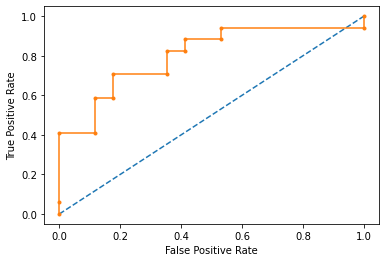

Area Under Curve = 0.80


In [ ]:
# predict probabilities
yhat = best_model.predict_proba(lasso_test)
# retrieve just the probabilities for the positive class
pos_probs = yhat[:, 1]
# plot no skill roc curve
plt.plot([0, 1], [0, 1], linestyle='--')
# calculate roc curve for model
fpr, tpr, _ = roc_curve(test_label, pos_probs)
# plot model roc curve
plt.plot(fpr, tpr, marker='.')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the plot
plt.show()
# auc score
roc_auc = roc_auc_score(test_label, pos_probs)
print(f"Area Under Curve = {roc_auc:.2f}")